# Notebook Setup

In [ ]:
!pip uninstall torchaudio -y
!pip install gluonts
!pip install autogluon
!pip install pytorch-lightning==0.9.0rc2

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import csv
import subprocess

import pandas as pd

from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.metrics import mse
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

import scipy.stats as stats
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose

# Main

## Utils

In [72]:
def remove_outliers(df):

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    # Filter out the outliers
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))]


def load_data_pipeline(df, data_column, target_column):
    df = crime_data.groupby(data_column).sum()[target_column]
    df = remove_outliers(df)
    df = df.ffill()
    return df


def plot_train_test(train_set_bt, test_set_bt):
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

    train_set_bt.plot(ax=ax[0])
    ax[0].grid(which="both")
    ax[0].legend(["train series"], loc="upper left")

    test_set_bt.plot(ax=ax[1])
    ax[1].axvline(train_set_bt.index[-1], color="r")
    ax[1].grid(which="both")
    ax[1].legend(["test series", "end of train series"], loc="upper left")

    plt.show()


def analyze_normality(series):
    # Histogram
    plt.hist(series, bins=30)
    plt.title('Histogram')
    plt.show()

    # Q-Q plot
    stats.probplot(series, dist="norm", plot=plt)
    plt.title('Q-Q plot')
    plt.show()

    # Box-Cox transformation
    transformed, _ = boxcox(series)

    # Histogram of transformed data
    plt.hist(transformed, bins=30)
    plt.title('Histogram after Box-Cox transformation')
    plt.show()

    # Q-Q plot of transformed data
    stats.probplot(transformed, dist="norm", plot=plt)
    plt.title('Q-Q plot after Box-Cox transformation')
    plt.show()


def time_series_analysis(series):
    # Basic statistics
    print(series.describe())

    # Plot the time series
    series.plot()
    plt.title('Time Series Plot')
    plt.show()

    # If your data is daily
    series = series.asfreq('D')

    # Decompose the time series
    decomposition = seasonal_decompose(series)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the decomposition
    plt.figure(figsize=(10,10))

    plt.subplot(411)
    plt.plot(series, label='Original')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


def prepross_data(series, data_column, target_column):
    pd_dt = series.reset_index()
    pd_dt['item_id'] = 1
    pd_dt.rename(columns={data_column: 'start',
                   target_column: 'target',
                   'item_id': 'item_id'}, inplace=True)
    return pd_dt[['item_id','start','target']]

## Data Crime


#### Load Data

In [3]:
def load_csv_file(path_file):
    return pd.read_csv(path_file, parse_dates=['crimedate'])

In [4]:
data_path = '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/Data/bpd_part_1_victim_based_crime_data.csv'

crime_data = load_csv_file(data_path)

In [55]:
crime_data_days = load_data_pipeline(crime_data, 'crimedate', 'total_incidents')

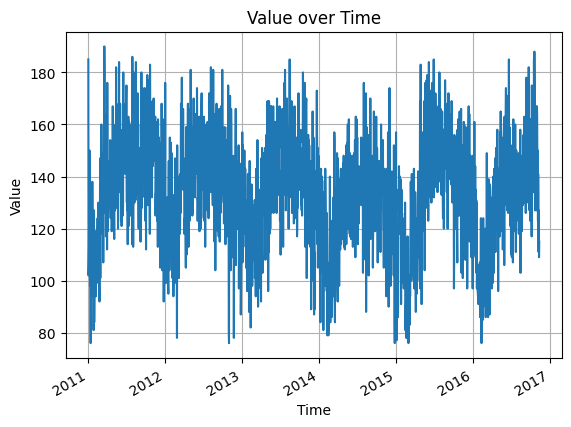

In [57]:
crime_data_days.plot()
plt.title('Value over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [11]:
# Assuming df is your DataFrame
train_size = int(len(crime_data_days) * 0.8)
train_set_bt = crime_data_days[:train_size]
test_set_bt = crime_data_days

LENGTH_TEST = len(test_set_bt) - len(train_set_bt)

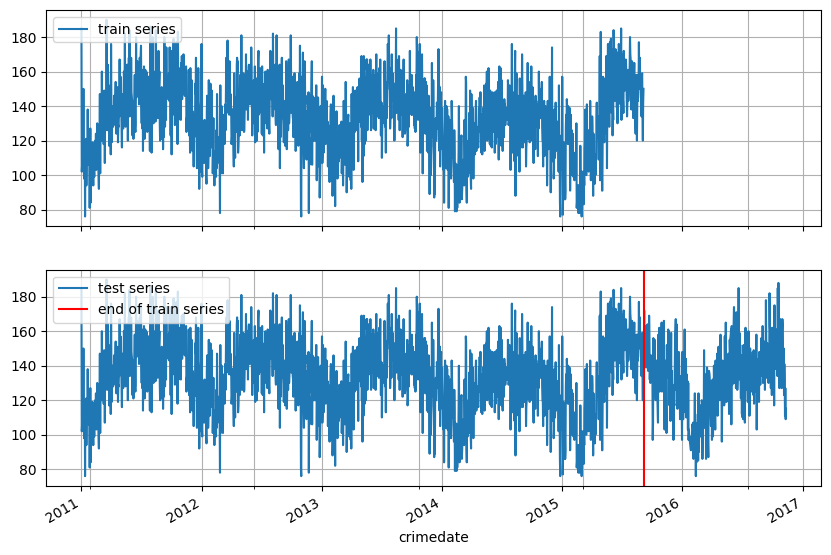

In [59]:
plot_train_test(train_set_bt, test_set_bt)

#### Descriptive Analysis

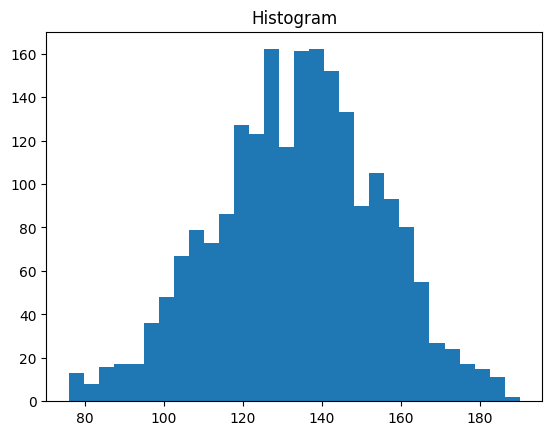

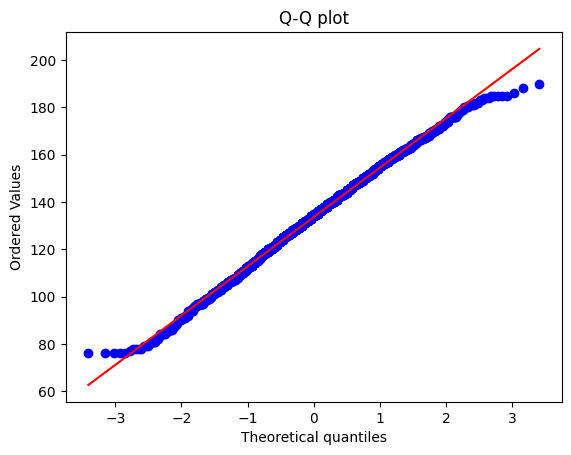

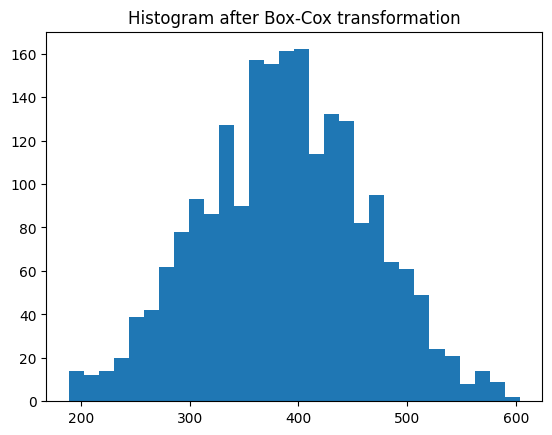

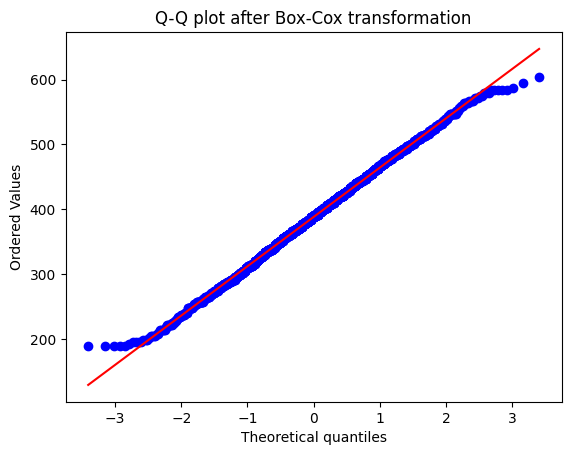

In [62]:
analyze_normality(test_set_bt)

#### Preprocess Data

In [76]:
train_set_dt,test_set_dt = prepross_data(train_set_bt, 'crimedate', 'total_incidents'),\
                           prepross_data(test_set_bt, 'crimedate', 'total_incidents')

train_data = TimeSeriesDataFrame.from_data_frame(
    train_set_dt,
    id_column="item_id",
    timestamp_column="start"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_set_dt,
    id_column="item_id",
    timestamp_column="start"
)

train_data = train_data.\
    reset_index()\
    .groupby('item_id', sort=False)\
    .resample('D', on='timestamp')\
    .sum().drop(columns=['item_id'])

test_data = test_data\
    .reset_index()\
    .groupby('item_id', sort=False)\
    .resample('D', on='timestamp')\
    .sum().drop(columns=['item_id'])

#### Fast Training

In [20]:
multiple_timeseries_path = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/crime_model_test"
model_path = "crime-quarterly-fast"
path = os.path.join(multiple_timeseries_path, model_path)

##### Model Training

In [ ]:
%%time
predictor = TimeSeriesPredictor(
    prediction_length=LENGTH_TEST,
    path= path,
    target="target",
    eval_metric="MSE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    random_seed=42
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/crime_model_test/crime-quarterly-fast'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          8
GPU Count:          0
Memory Avail:       48.58 GB / 50.99 GB (95.3%)
Disk Space Avail:   3.21 GB / 15.00 GB (21.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 424,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 

CPU times: user 47.2 s, sys: 1.14 s, total: 48.3 s
Wall time: 1min 27s


##### Loading Model

In [22]:
# Zip the model into a file called tourism-quarterly-fast.zip
# Delete the model path tourism-quarterly-fast.zip
# Recover the model tourism-quarterly-fast.zip and load it again

# !cd multiple-timeseries && zip -r -q tourism-quarterly-fast.zip tourism-quarterly-fast
subprocess.run(["zip", "-r", "-q", f"{model_path}.zip", model_path], cwd=multiple_timeseries_path)

# !cd multiple-timeseries && rm -r tourism-quarterly-fast
subprocess.run(["rm", "-r", model_path], cwd=multiple_timeseries_path)

# !cd multiple-timeseries && unzip tourism-quarterly-fast.zip
subprocess.run(["unzip", f"{model_path}.zip"], cwd=multiple_timeseries_path)
predictor = TimeSeriesPredictor.load(path,require_version_match=False)

In [23]:
predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
              model    score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -624.405843      10.708809           0.796278          7
1     DirectTabular  -628.401228       0.143278           0.903677          6
2               ETS  -813.663048      29.570607           0.010475          3
3             Theta  -814.929692      33.147235           0.010083          4
4             Naive  -883.327830       2.285523           0.010139          1
5     SeasonalNaive  -991.219340       1.358630           0.009488          2
6  RecursiveTabular -1185.110339      10.565530           4.505798          5
Number of models trained: 7
Types of models trained:
{'TimeSeriesGreedyEnsemble', 'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


{'model_types': {'Naive': 'MultiWindowBacktestingModel',
  'SeasonalNaive': 'MultiWindowBacktestingModel',
  'ETS': 'MultiWindowBacktestingModel',
  'Theta': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'Naive': -883.3278301886793,
  'SeasonalNaive': -991.2193396226415,
  'ETS': -813.6630484662436,
  'Theta': -814.9296919698761,
  'RecursiveTabular': -1185.1103394045576,
  'DirectTabular': -628.401228178806,
  'WeightedEnsemble': -624.4058426435391},
 'model_best': 'WeightedEnsemble',
 'model_paths': {'Naive': ['Naive'],
  'SeasonalNaive': ['SeasonalNaive'],
  'ETS': ['ETS'],
  'Theta': ['Theta'],
  'RecursiveTabular': ['RecursiveTabular'],
  'DirectTabular': ['DirectTabular'],
  'WeightedEnsemble': ['WeightedEnsemble']},
 'model_fit_times': {'Naive': 0.010138988494873047,
  'SeasonalNaive': 0.009488105773925781,
  'ETS': 0.0

##### Model Evaluation

In [ ]:
predictions = predictor.predict(train_data, random_seed=42)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2015-09-06  128.066895   99.709952  109.444305  116.463457   
        2015-09-07  129.123749   89.020996  102.787449  112.714030   
        2015-09-08  125.592026   76.476383   93.336776  105.494305   
        2015-09-09  122.430878   65.717024   85.185728   99.224034   
        2015-09-10  130.686035   67.278007   89.044680  104.739983   
...                        ...         ...         ...         ...   
        2016-10-29  131.835938 -449.308233 -249.813377 -105.963550   
        2016-10-30  126.369156 -455.466425 -255.734217 -111.713242   
        2016-10-31  127.586899 -454.939299 -254.970019 -110.778100   
        2016-11-01  149.292694 -433.923285 -233.717215  -89.354554   
        2016-11-02  134.590820 -449.314133 -248.871553 -104.338350   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2015-09-06  122.461065  128.066884  133.672703  139.670310   
        2015-09-07  121.195928  129.123754  137.051579  145.533477   
        2015-09-08  115.882466  125.592030  135.301593  145.689754   
        2015-09-09  111.219248  122.430887  133.642526  145.637740   
        2015-09-10  118.151040  130.686033  143.221026  156.632084   
...                        ...         ...         ...         ...   
        2016-10-29   16.950823  131.835931  246.721039  369.635412   
        2016-10-30   11.347370  126.369165  241.390960  364.451572   
        2016-10-31   12.428578  127.586898  242.745217  365.951896   
        2016-11-01   33.998018  149.292700  264.587382  387.939954   
        2016-11-02   19.159942  134.590826  250.021710  373.520002   

                           0.8         0.9  
item_id timestamp                           
1       2015-09-06  146.689463  156.423816  
        2015-09-07  155.460058  169.226511  
        2015-09-08  157.847283  174.707676  
        2015-09-09  159.676046  179.144750  
        2015-09-10  172.327387  194.094060  
...                        ...         ...  
        2016-10-29  513.485238  712.980094  
        2016-10-30  508.472547  708.204755  
        2016-10-31  510.143815  710.113094  
        2016-11-01  532.302615  732.508685  
        2016-11-02  518.053205  718.495785  

[424 rows x 10 columns]

In [ ]:
def plot_data(df, true_pred):
    plt.figure(figsize=(10, 6))

    # Plot the mean as a line
    plt.plot(df.index.get_level_values('timestamp'), df['mean'], label='mean', color='red')

    true_pred = true_pred.reset_index()
    # Plot the true predictions as a line
    plt.plot(true_pred['timestamp'], true_pred['target'], label='target', color='green')

    # Plot the other quantiles as an area plot
    for column in df.columns:
        if column != 'mean':
            pass
            #upper = df['mean'] + (df['mean'] - df[column])
            #lower = df['mean'] - (df['mean'] - df[column])
            #plt.fill_between(df.index.get_level_values('timestamp'), upper, lower, color='blue', alpha=0.1)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


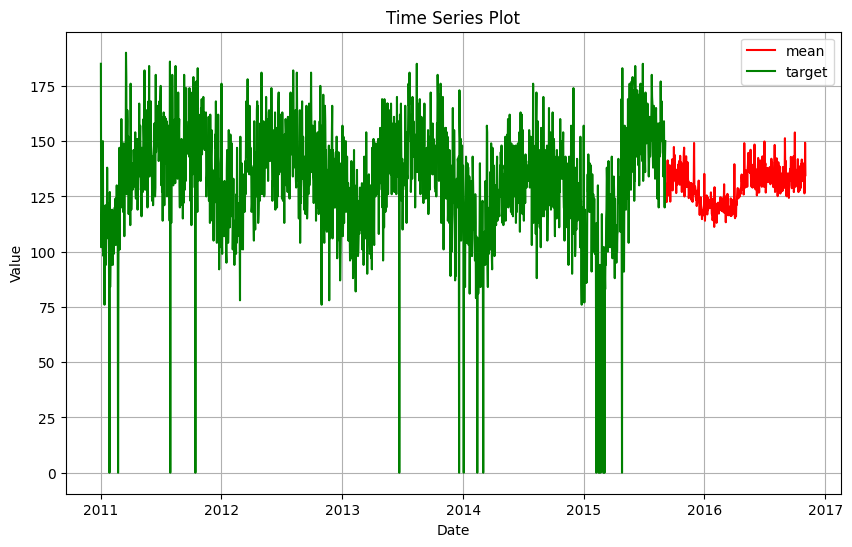

In [ ]:
plot_data(predictions,train_data)

In [ ]:
fast_valid_loss = predictor.evaluate(train_data)
fast_test_loss = predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:
fast_test_loss

{'MSE': -641.3644100430527}

In [ ]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-641.364410,-624.405843,10.185112,10.708809,0.796278,7
1,DirectTabular,-641.835982,-628.401228,0.145508,0.143278,0.903677,6
2,Naive,-831.702830,-883.327830,0.097547,2.285523,0.010139,1
3,Theta,-1034.441492,-814.929692,32.206705,33.147235,0.010083,4
4,ETS,-1050.446279,-813.663048,0.617424,29.570607,0.010475,3
5,RecursiveTabular,-1052.624471,-1185.110339,10.034516,10.565530,4.505798,5
6,SeasonalNaive,-1082.808962,-991.219340,0.073361,1.358630,0.009488,2


In [ ]:
def plot_single_timeseries(train_data, predictions, test_data, item_id):
    plt.figure(figsize=(30, 9))

    y_past = train_data.loc[item_id]["target"]
    y_pred = predictions.loc[item_id]
    y_test = test_data.loc[item_id]["target"][-LENGTH_TEST:]

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.plot(y_past[-100:], label="Past Time Series", color=colors[0], linestyle='-')
    plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
    plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

    #plt.fill_between( y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Predictions for Item {item_id}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_multiple_timeseries(train_data, predictions, test_data, item_ids_to_plot):

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.figure(figsize=(13, 13))
    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(5, 1, i + 1)

        y_past = train_data.loc[item_id]["target"]
        y_pred = predictions.loc[item_id]
        y_test = test_data.loc[item_id]["target"][-LENGTH_TEST:]

        plt.plot(y_past[-100:], label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

        #plt.fill_between(y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_single_timeseries(train_data, predictions, test_data, item_id=1)

#### Best Quality

In [24]:
multiple_timeseries_path = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/crime_model_test"
model_path = "crime-quarterly-best"
path = os.path.join(multiple_timeseries_path, model_path)

##### Model Training

In [ ]:
%%time

predictor = TimeSeriesPredictor(
    prediction_length=LENGTH_TEST,
    path=path,
    target="target",
    eval_metric="MSE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    random_seed=42
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/crime_model_test/crime-quarterly-best'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          8
GPU Count:          0
Memory Avail:       47.50 GB / 50.99 GB (93.1%)
Disk Space Avail:   3.21 GB / 15.00 GB (21.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 424,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'tar

CPU times: user 5h 12min 36s, sys: 2h 15min 38s, total: 7h 28min 15s
Wall time: 2h 4min 16s


##### Loading Model

In [25]:
# Zip the model into a file called tourism-quarterly-fast.zip
# Delete the model path tourism-quarterly-fast.zip
# Recover the model tourism-quarterly-fast.zip and load it again

# !cd multiple-timeseries && zip -r -q tourism-quarterly-fast.zip tourism-quarterly-fast
subprocess.run(["zip", "-r", "-q", f"{model_path}.zip", model_path], cwd=multiple_timeseries_path)

# !cd multiple-timeseries && rm -r tourism-quarterly-fast
subprocess.run(["rm", "-r", model_path], cwd=multiple_timeseries_path)

# !cd multiple-timeseries && unzip tourism-quarterly-fast.zip
subprocess.run(["unzip", f"{model_path}.zip"], cwd=multiple_timeseries_path)
predictor = TimeSeriesPredictor.load(path,require_version_match=False)

In [26]:
predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
                        model    score_val  pred_time_val  fit_time_marginal  \
0            WeightedEnsemble  -492.651582       0.223363           2.687386   
1   TemporalFusionTransformer  -492.985490       0.080494        5020.230563   
2               DirectTabular  -571.491049       0.142869           1.725293   
3                    PatchTST  -587.464164       0.077034         165.112463   
4                        NPTS  -719.903872       4.329979           3.204142   
5                   AutoARIMA  -728.674191      15.959448          15.877043   
6                  CrostonSBA  -732.261281       2.384253           3.829554   
7       DynamicOptimizedTheta  -735.303682      31.849146           0.436843   
8                     AutoETS  -735.897535      13.716226           0.334046   
9                      DeepAR  -835.864913       2.110878        2138.080169   
10           RecursiveTabula

{'model_types': {'SeasonalNaive': 'MultiWindowBacktestingModel',
  'CrostonSBA': 'MultiWindowBacktestingModel',
  'NPTS': 'MultiWindowBacktestingModel',
  'AutoETS': 'MultiWindowBacktestingModel',
  'DynamicOptimizedTheta': 'MultiWindowBacktestingModel',
  'AutoARIMA': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'DeepAR': 'MultiWindowBacktestingModel',
  'TemporalFusionTransformer': 'MultiWindowBacktestingModel',
  'PatchTST': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'SeasonalNaive': -1115.569575471698,
  'CrostonSBA': -732.2612805646484,
  'NPTS': -719.9038718160377,
  'AutoETS': -735.897535194407,
  'DynamicOptimizedTheta': -735.3036824953456,
  'AutoARIMA': -728.6741907725393,
  'RecursiveTabular': -921.1157223701098,
  'DirectTabular': -571.491048775035,
  'DeepAR': -835.8649129518001,
  'TemporalFusionTransformer': -492.9854903

##### Model Eval

In [43]:
predictions = predictor.predict(train_data, random_seed=42)
predictions

mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2015-09-06  127.402039  105.099627  113.932811  127.157324   
        2015-09-07  131.303360  108.883405  117.844383  125.138546   
        2015-09-08  130.566071  107.877458  115.475193  122.633114   
        2015-09-09  130.837418  106.939402  114.530971  121.297832   
        2015-09-10  134.542542  108.053284  116.727760  123.056343   
...                        ...         ...         ...         ...   
        2016-10-29  132.017670   69.284774   93.395969  109.060474   
        2016-10-30  118.279427   62.139943   81.929908   95.718726   
        2016-10-31  129.391479   71.712354   91.610858  106.182538   
        2016-11-01  134.685852   76.368721   96.810333  112.477417   
        2016-11-02  134.126633   74.447121   95.531227  111.565469   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2015-09-06  125.843749  127.402039  138.279680  140.096521   
        2015-09-07  126.145070  131.303355  142.583145  146.319833   
        2015-09-08  125.262299  130.566073  141.819111  145.420167   
        2015-09-09  125.174809  130.837416  141.022332  145.178171   
        2015-09-10  128.133594  134.542538  142.359022  147.377793   
...                        ...         ...         ...         ...   
        2016-10-29  121.630347  132.017677  143.660562  156.066448   
        2016-10-30  109.748790  118.279426  130.129780  141.857262   
        2016-10-31  117.887123  129.391484  144.642724  156.023166   
        2016-11-01  121.990904  134.685853  150.440960  162.161463   
        2016-11-02  121.317818  134.126639  149.816297  161.817494   

                           0.8         0.9  
item_id timestamp                           
1       2015-09-06  145.919294  157.710387  
        2015-09-07  153.865155  159.449325  
        2015-09-08  154.130761  160.697345  
        2015-09-09  153.829866  161.899981  
        2015-09-10  155.145860  164.820656  
...                        ...         ...  
        2016-10-29  170.144459  189.565476  
        2016-10-30  157.964714  178.441706  
        2016-10-31  172.609908  188.240208  
        2016-11-01  179.133365  194.792155  
        2016-11-02  179.259214  194.966848  

[424 rows x 10 columns]

In [33]:
def plot_data(df, true_pred):
    plt.figure(figsize=(10, 6))

    # Plot the mean as a line
    plt.plot(df.index.get_level_values('timestamp'), df['mean'], label='mean', color='red')

    true_pred = true_pred.reset_index()
    # Plot the true predictions as a line
    plt.plot(true_pred['timestamp'], true_pred['target'], label='target', color='green')

    # Plot the other quantiles as an area plot
    for column in df.columns:
        if column != 'mean':
            pass
            upper = df['mean'] + (df['mean'] - df[column])
            lower = df['mean'] - (df['mean'] - df[column])
            plt.fill_between(df.index.get_level_values('timestamp'), upper, lower, color='blue', alpha=0.1)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


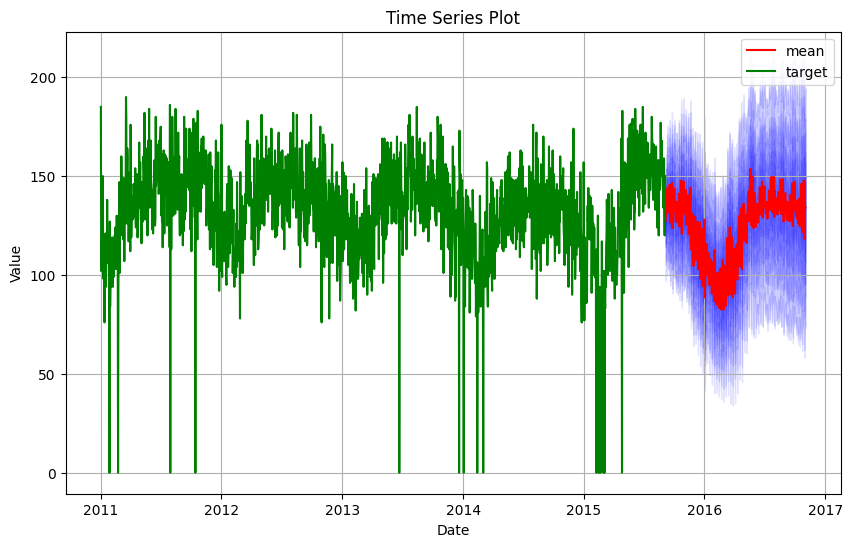

In [44]:
plot_data(predictions,train_data)

In [30]:
fast_valid_loss = predictor.evaluate(train_data)
fast_test_loss = predictor.evaluate(test_data)

In [31]:
fast_test_loss

{'MSE': -563.8071499300289}

In [32]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-563.807150,-492.651582,0.296338,0.223363,2.687386,12
1,TemporalFusionTransformer,-568.277432,-492.985490,0.126783,0.080494,5020.230563,10
2,DirectTabular,-641.835982,-571.491049,0.163363,0.142869,1.725293,8
3,NPTS,-719.397621,-719.903872,7.347000,4.329979,3.204142,3
4,CrostonSBA,-861.632738,-732.261281,11.420956,2.384253,3.829554,2
5,PatchTST,-868.553498,-587.464164,0.188005,0.077034,165.112463,11
6,RecursiveTabular,-970.875626,-921.115722,24.464432,14.911284,19.034259,7
7,DynamicOptimizedTheta,-1049.709396,-735.303682,38.154012,31.849146,0.436843,5
8,AutoETS,-1050.446279,-735.897535,27.626837,13.716226,0.334046,4
9,DeepAR,-1064.148660,-835.864913,2.604245,2.110878,2138.080169,9


In [38]:
def plot_single_timeseries(train_data, predictions, test_data, item_id):
    plt.figure(figsize=(30, 9))

    y_past = train_data.loc[item_id]["target"]
    y_pred = predictions.loc[item_id]
    y_test = test_data.loc[item_id]["target"][-LENGTH_TEST:]

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.plot(y_past[-100:], label="Past Time Series", color=colors[0], linestyle='-')
    plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
    plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

    plt.fill_between( y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Predictions for Item {item_id}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_multiple_timeseries(train_data, predictions, test_data, item_ids_to_plot):

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.figure(figsize=(13, 13))
    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(5, 1, i + 1)

        y_past = train_data.loc[item_id]["target"]
        y_pred = predictions.loc[item_id]
        y_test = test_data.loc[item_id]["target"][-LENGTH_TEST:]

        plt.plot(y_past[-100:], label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

        #plt.fill_between(y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

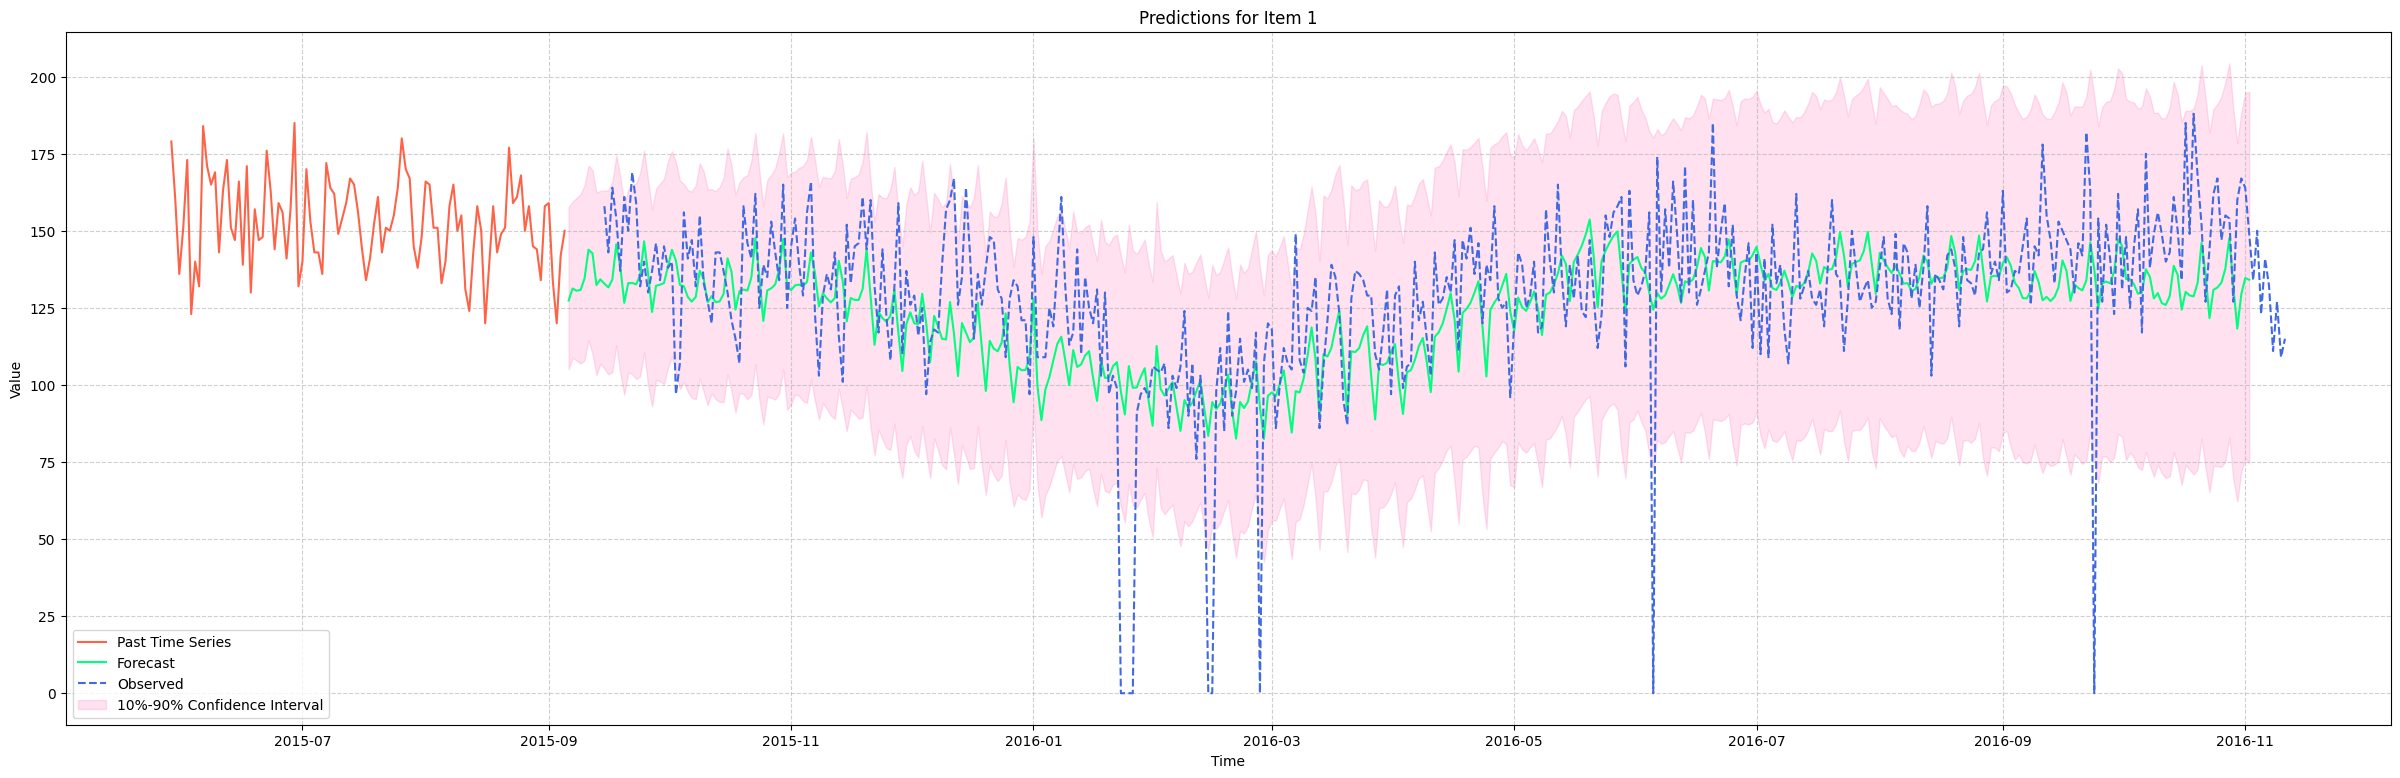

In [45]:
plot_single_timeseries(train_data, predictions, test_data, item_id=1)

## BitCoin ex


#### Load Data

In [ ]:
path_data = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/Data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

bitcoin_data = pd.read_csv(path_data)

bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'],
                                           unit='s')

bitcoin_data.set_index('Timestamp', inplace=True)

In [ ]:
bitcoin_data

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


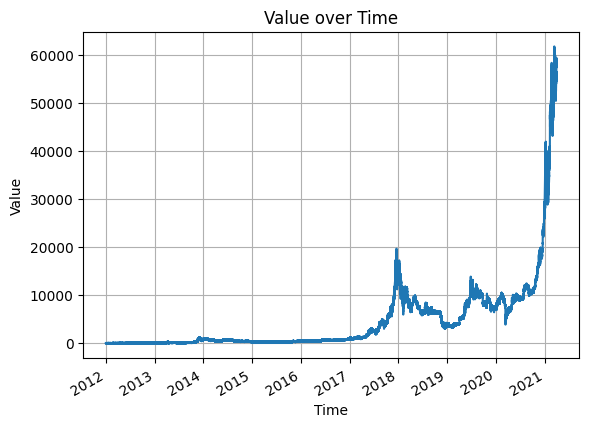

In [ ]:
bitcoin_data['Open'].plot()
plt.title('Value over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
# Resample and compute mean
bitcoin_data_daily_mean = bitcoin_data['Open'].resample('D').mean()

bitcoin_data_daily_mean = bitcoin_data_daily_mean.ffill()

In [ ]:
bitcoin_data_daily_mean

Timestamp
2011-12-31        4.465000
2012-01-01        4.806667
2012-01-02        5.000000
2012-01-03        5.252500
2012-01-04        5.200000
                  ...     
2021-03-27    55193.240643
2021-03-28    55833.608471
2021-03-29    56914.886595
2021-03-30    58347.805624
2021-03-31    58767.750000
Freq: D, Name: Open, Length: 3379, dtype: float64

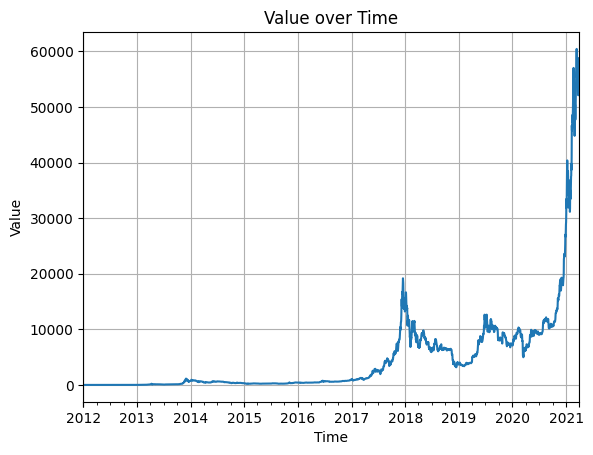

In [ ]:
bitcoin_data_daily_mean.plot()
plt.title('Value over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
# Assuming df is your DataFrame
train_size = int(len(bitcoin_data_daily_mean) * 0.8)
train_set_bt = bitcoin_data_daily_mean[:train_size]
test_set_bt = bitcoin_data_daily_mean

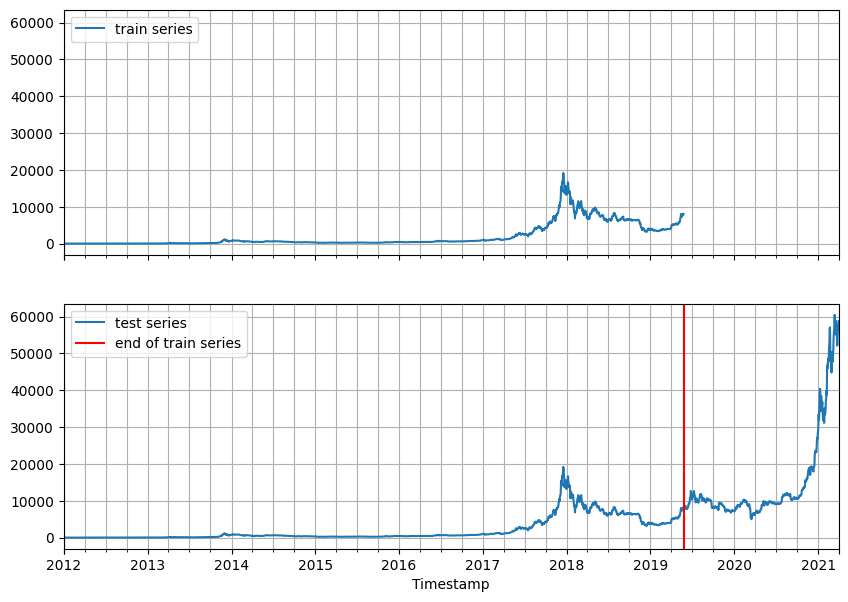

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_set_bt.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_set_bt.plot(ax=ax[1])
ax[1].axvline(train_set_bt.index[-1], color="r")
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

#### Preprocess Data

In [ ]:
def prepross_data(series):
    pd_dt = series.reset_index()
    pd_dt['item_id'] = 1
    pd_dt.rename(columns={'Timestamp': 'start',
                   'Open': 'target',
                   'item_id': 'item_id'}, inplace=True)
    return pd_dt[['item_id','start','target']]

In [ ]:
train_set_dt,test_set_dt = prepross_data(train_set_bt),prepross_data(test_set_bt)

In [ ]:
train_set_dt

,item_id,start,target
0,1,2011-12-31,4.465000
1,1,2012-01-01,4.806667
2,1,2012-01-02,5.000000
3,1,2012-01-03,5.252500
4,1,2012-01-04,5.200000
...,...,...,...
2698,1,2019-05-21,7953.413136
2699,1,2019-05-22,7891.084232
2700,1,2019-05-23,7703.329006
2701,1,2019-05-24,7983.513972


In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_set_dt,
    id_column="item_id",
    timestamp_column="start"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_set_dt,
    id_column="item_id",
    timestamp_column="start"
)

test_data

target
item_id timestamp               
1       2011-12-31      4.465000
        2012-01-01      4.806667
        2012-01-02      5.000000
        2012-01-03      5.252500
        2012-01-04      5.200000
...                          ...
        2021-03-27  55193.240643
        2021-03-28  55833.608471
        2021-03-29  56914.886595
        2021-03-30  58347.805624
        2021-03-31  58767.750000

[3379 rows x 1 columns]

In [ ]:
train_data = train_data.\
    reset_index()\
    .groupby('item_id', sort=False)\
    .resample('D', on='timestamp')\
    .sum().drop(columns=['item_id'])

test_data = test_data\
    .reset_index()\
    .groupby('item_id', sort=False)\
    .resample('D', on='timestamp')\
    .sum().drop(columns=['item_id'])

#### Fast Training

##### Model Training

In [ ]:
%%time
multiple_timeseries_path = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test"
model_path_fast = "bitcoin-quarterly-fast"
path = os.path.join(multiple_timeseries_path, model_path_fast)

predictor = TimeSeriesPredictor(
    prediction_length=676,
    path= path,
    target="target",
    eval_metric="MSE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    random_seed=42
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test/bitcoin-quarterly-fast'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          8
GPU Count:          0
Memory Avail:       47.49 GB / 50.99 GB (93.1%)
Disk Space Avail:   3.27 GB / 15.00 GB (21.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 676,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': Fals

CPU times: user 53.9 s, sys: 630 ms, total: 54.5 s
Wall time: 42.5 s


##### Loading Model

In [ ]:
# Zip the model into a file called tourism-quarterly-fast.zip
# Delete the model path tourism-quarterly-fast.zip
# Recover the model tourism-quarterly-fast.zip and load it again

# !cd multiple-timeseries && zip -r -q tourism-quarterly-fast.zip tourism-quarterly-fast
subprocess.run(["zip", "-r", "-q", f"{model_path_fast}.zip", model_path_fast], cwd=multiple_timeseries_path)

# !cd multiple-timeseries && rm -r tourism-quarterly-fast
subprocess.run(["rm", "-r", model_path_fast], cwd=multiple_timeseries_path)

# !cd multiple-timeseries && unzip tourism-quarterly-fast.zip
subprocess.run(["unzip", f"{model_path_fast}.zip"], cwd=multiple_timeseries_path)
predictor = TimeSeriesPredictor.load(path,require_version_match=False)

Loading predictor from path /content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test/bitcoin-quarterly-fast


In [ ]:
predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
              model     score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble -2.788917e+07       3.108365           0.927974          7
1               ETS -2.788917e+07       3.108365           0.012622          3
2             Theta -2.833879e+07      19.794358           0.011824          4
3             Naive -2.902806e+07       1.527169           0.011921          1
4     SeasonalNaive -2.985244e+07       0.110182           0.012780          2
5  RecursiveTabular -3.269251e+07      13.866979           1.396267          5
6     DirectTabular -5.079302e+07       0.206210           1.116005          6
Number of models trained: 7
Types of models trained:
{'MultiWindowBacktestingModel', 'TimeSeriesGreedyEnsemble'}
****************** End of fit() summary ******************


{'model_types': {'Naive': 'MultiWindowBacktestingModel',
  'SeasonalNaive': 'MultiWindowBacktestingModel',
  'ETS': 'MultiWindowBacktestingModel',
  'Theta': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'Naive': -29028061.509347815,
  'SeasonalNaive': -29852435.857535787,
  'ETS': -27889171.38652906,
  'Theta': -28338789.44814589,
  'RecursiveTabular': -32692509.7416185,
  'DirectTabular': -50793018.362890966,
  'WeightedEnsemble': -27889171.38652906},
 'model_best': 'ETS',
 'model_paths': {'Naive': ['Naive'],
  'SeasonalNaive': ['SeasonalNaive'],
  'ETS': ['ETS'],
  'Theta': ['Theta'],
  'RecursiveTabular': ['RecursiveTabular'],
  'DirectTabular': ['DirectTabular'],
  'WeightedEnsemble': ['WeightedEnsemble']},
 'model_fit_times': {'Naive': 0.011921405792236328,
  'SeasonalNaive': 0.012779712677001953,
  'ETS': 0.012622117996

##### Model Evaluation

In [ ]:
predictions = predictor.predict(train_data, random_seed=42)
predictions

Model not specified in predict, will default to the model with the best validation score: ETS


mean           0.1           0.2            0.3  \
item_id timestamp                                                             
1       2019-05-26   8104.452862  7.695944e+03  7.836177e+03    7937.294526   
        2019-05-27   8162.626552  7.575528e+03  7.777067e+03    7922.390541   
        2019-05-28   8220.800243  7.490172e+03  7.740981e+03    7921.832941   
        2019-05-29   8278.973934  7.421855e+03  7.716086e+03    7928.247825   
        2019-05-30   8337.147624  7.363717e+03  7.697875e+03    7938.827500   
...                          ...           ...           ...            ...   
        2021-03-27  47138.999245 -1.507375e+06 -9.737422e+05 -588955.462964   
        2021-03-28  47197.172936 -1.518990e+06 -9.813503e+05 -593674.028976   
        2021-03-29  47255.346626 -1.530693e+06 -9.890158e+05 -598428.392185   
        2021-03-30  47313.520317 -1.542484e+06 -9.967393e+05 -603218.821185   
        2021-03-31  47371.694007 -1.554364e+06 -1.004521e+06 -608045.586587   

                              0.4           0.5            0.6            0.7  \
item_id timestamp                                                               
1       2019-05-26    8023.695732   8104.452862    8185.209991    8271.611197   
        2019-05-27    8046.564314   8162.626552    8278.688791    8402.862564   
        2019-05-28    8076.363886   8220.800243    8365.236600    8519.767545   
        2019-05-29    8109.531987   8278.973934    8448.415880    8629.700043   
        2019-05-30    8144.712173   8337.147624    8529.583076    8735.467748   
...                           ...           ...            ...            ...   
        2021-03-27 -260169.413726  47138.999245  354447.412216  683233.461455   
        2021-03-28 -262418.966929  47197.172936  356813.312800  688068.374848   
        2021-03-29 -264685.814386  47255.346626  359196.507639  692939.085437   
        2021-03-30 -266970.085861  47313.520317  361597.126495  697845.861819   
        2021-03-31 -269271.912091  47371.694007  364015.300106  702788.974602   

                             0.8           0.9  
item_id timestamp                               
1       2019-05-26  8.372729e+03  8.512961e+03  
        2019-05-27  8.548186e+03  8.749725e+03  
        2019-05-28  8.700619e+03  8.951429e+03  
        2019-05-29  8.841862e+03  9.136093e+03  
        2019-05-30  8.976420e+03  9.310579e+03  
...                          ...           ...  
        2021-03-27  1.068020e+06  1.601653e+06  
        2021-03-28  1.075745e+06  1.613385e+06  
        2021-03-29  1.083527e+06  1.625204e+06  
        2021-03-30  1.091366e+06  1.637111e+06  
        2021-03-31  1.099264e+06  1.649107e+06  

[676 rows x 10 columns]

In [ ]:
def plot_data(df, true_pred):
    plt.figure(figsize=(10, 6))

    # Plot the mean as a line
    plt.plot(df.index.get_level_values('timestamp'), df['mean'], label='mean', color='red')

    true_pred = true_pred.reset_index()
    # Plot the true predictions as a line
    plt.plot(true_pred['timestamp'], true_pred['target'], label='target', color='green')

    # Plot the other quantiles as an area plot
    for column in df.columns:
        if column != 'mean':
            pass
            #upper = df['mean'] + (df['mean'] - df[column])
            #lower = df['mean'] - (df['mean'] - df[column])
            #plt.fill_between(df.index.get_level_values('timestamp'), upper, lower, color='blue', alpha=0.1)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


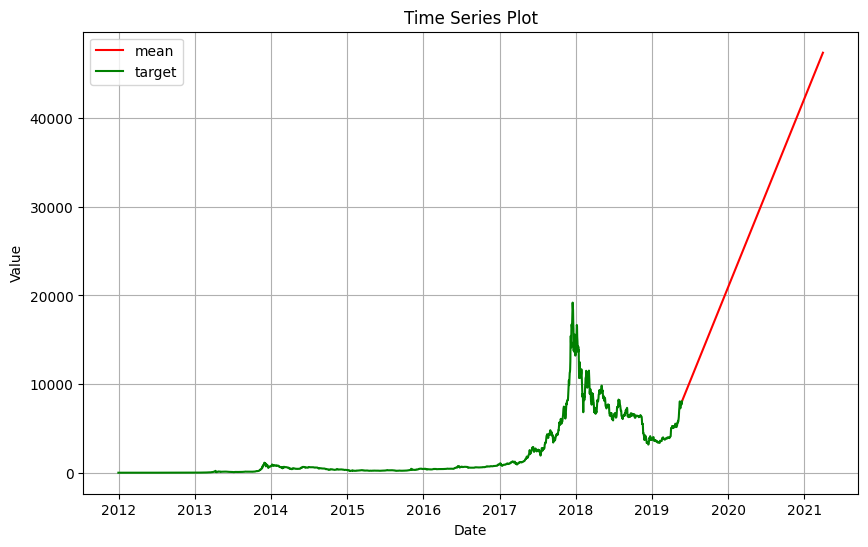

In [ ]:
plot_data(predictions,train_data)

In [ ]:
fast_valid_loss = predictor.evaluate(train_data)
fast_test_loss = predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: ETS
Model not specified in predict, will default to the model with the best validation score: ETS


In [ ]:
fast_test_loss

{'MSE': -259721066.99212298}

In [ ]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-1.568038e+07,-4.014605e+06,0.603934,0.513978,2.443433,5
1,Theta,-4.083240e+07,-3.765652e+06,0.349050,35.678625,0.011284,4
2,Naive,-4.216939e+07,-3.774964e+06,0.032551,1.784512,0.013654,1
3,WeightedEnsemble,-4.217164e+07,-2.883733e+06,32.818547,34.346917,0.796631,7
4,ETS,-4.217164e+07,-2.883733e+06,32.812495,34.346917,0.012521,3
5,SeasonalNaive,-6.016340e+07,-4.055622e+06,0.040835,1.431256,0.015574,2
6,DirectTabular,-1.608432e+09,-1.082882e+07,0.132187,0.107737,1.629050,6


In [ ]:
def plot_single_timeseries(train_data, predictions, test_data, item_id):
    plt.figure(figsize=(15, 3))

    y_past = train_data.loc[item_id]["target"]
    y_pred = predictions.loc[item_id]
    y_test = test_data.loc[item_id]["target"][-676:]

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.plot(y_past[-1000:], label="Past Time Series", color=colors[0], linestyle='-')
    plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
    plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

    #plt.fill_between( y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Predictions for Item {item_id}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_multiple_timeseries(train_data, predictions, test_data, item_ids_to_plot):

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.figure(figsize=(13, 13))
    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(5, 1, i + 1)

        y_past = train_data.loc[item_id]["target"]
        y_pred = predictions.loc[item_id]
        y_test = test_data.loc[item_id]["target"][-676:]

        plt.plot(y_past[-1000:], label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

        #plt.fill_between(y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

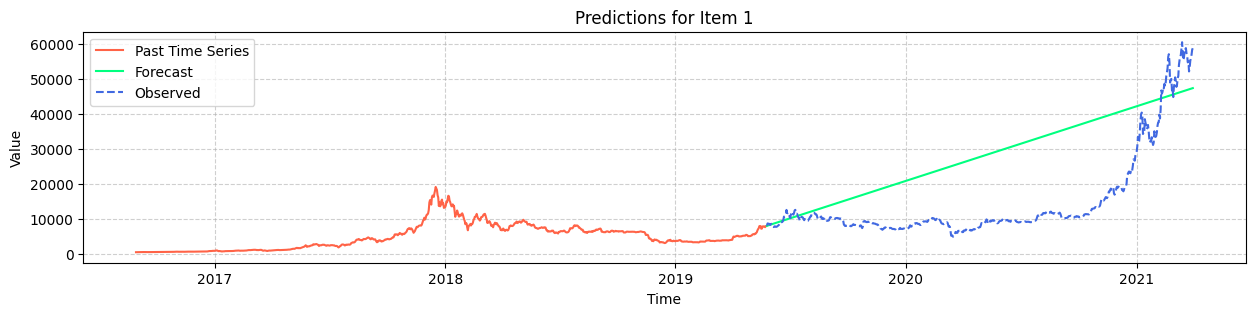

In [ ]:
plot_single_timeseries(train_data, predictions, test_data, item_id=1)

#### Medium Quality

##### Model Training

In [ ]:
%%time
multiple_timeseries_path = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test"
model_path_medium_quality = "bitcoin-quarterly-medium_quality"
path = os.path.join(multiple_timeseries_path, model_path_medium_quality)

predictor = TimeSeriesPredictor(
    prediction_length=676,
    path=path,
    target="target",
    eval_metric="MSE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    random_seed=42
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test/bitcoin-quarterly-medium_quality'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          8
GPU Count:          0
Memory Avail:       47.16 GB / 50.99 GB (92.5%)
Disk Space Avail:   3.26 GB / 15.00 GB (21.7%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 676,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full'

CPU times: user 55.1 s, sys: 646 ms, total: 55.8 s
Wall time: 23 s


##### Model Eval

In [ ]:
predictions = predictor.predict(train_data, random_seed=42)
predictions

Model not specified in predict, will default to the model with the best validation score: ETS


mean           0.1           0.2            0.3  \
item_id timestamp                                                             
1       2019-05-26   8104.452862  7.695944e+03  7.836177e+03    7937.294526   
        2019-05-27   8162.626552  7.575528e+03  7.777067e+03    7922.390541   
        2019-05-28   8220.800243  7.490172e+03  7.740981e+03    7921.832941   
        2019-05-29   8278.973934  7.421855e+03  7.716086e+03    7928.247825   
        2019-05-30   8337.147624  7.363717e+03  7.697875e+03    7938.827500   
...                          ...           ...           ...            ...   
        2021-03-27  47138.999245 -1.507375e+06 -9.737422e+05 -588955.462964   
        2021-03-28  47197.172936 -1.518990e+06 -9.813503e+05 -593674.028976   
        2021-03-29  47255.346626 -1.530693e+06 -9.890158e+05 -598428.392185   
        2021-03-30  47313.520317 -1.542484e+06 -9.967393e+05 -603218.821185   
        2021-03-31  47371.694007 -1.554364e+06 -1.004521e+06 -608045.586587   

                              0.4           0.5            0.6            0.7  \
item_id timestamp                                                               
1       2019-05-26    8023.695732   8104.452862    8185.209991    8271.611197   
        2019-05-27    8046.564314   8162.626552    8278.688791    8402.862564   
        2019-05-28    8076.363886   8220.800243    8365.236600    8519.767545   
        2019-05-29    8109.531987   8278.973934    8448.415880    8629.700043   
        2019-05-30    8144.712173   8337.147624    8529.583076    8735.467748   
...                           ...           ...            ...            ...   
        2021-03-27 -260169.413726  47138.999245  354447.412216  683233.461455   
        2021-03-28 -262418.966929  47197.172936  356813.312800  688068.374848   
        2021-03-29 -264685.814386  47255.346626  359196.507639  692939.085437   
        2021-03-30 -266970.085861  47313.520317  361597.126495  697845.861819   
        2021-03-31 -269271.912091  47371.694007  364015.300106  702788.974602   

                             0.8           0.9  
item_id timestamp                               
1       2019-05-26  8.372729e+03  8.512961e+03  
        2019-05-27  8.548186e+03  8.749725e+03  
        2019-05-28  8.700619e+03  8.951429e+03  
        2019-05-29  8.841862e+03  9.136093e+03  
        2019-05-30  8.976420e+03  9.310579e+03  
...                          ...           ...  
        2021-03-27  1.068020e+06  1.601653e+06  
        2021-03-28  1.075745e+06  1.613385e+06  
        2021-03-29  1.083527e+06  1.625204e+06  
        2021-03-30  1.091366e+06  1.637111e+06  
        2021-03-31  1.099264e+06  1.649107e+06  

[676 rows x 10 columns]

In [ ]:
def plot_data(df, true_pred):
    plt.figure(figsize=(10, 6))

    # Plot the mean as a line
    plt.plot(df.index.get_level_values('timestamp'), df['mean'], label='mean', color='red')

    true_pred = true_pred.reset_index()
    # Plot the true predictions as a line
    plt.plot(true_pred['timestamp'], true_pred['target'], label='target', color='green')

    # Plot the other quantiles as an area plot
    for column in df.columns:
        if column != 'mean':
            pass
            #upper = df['mean'] + (df['mean'] - df[column])
            #lower = df['mean'] - (df['mean'] - df[column])
            #plt.fill_between(df.index.get_level_values('timestamp'), upper, lower, color='blue', alpha=0.1)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


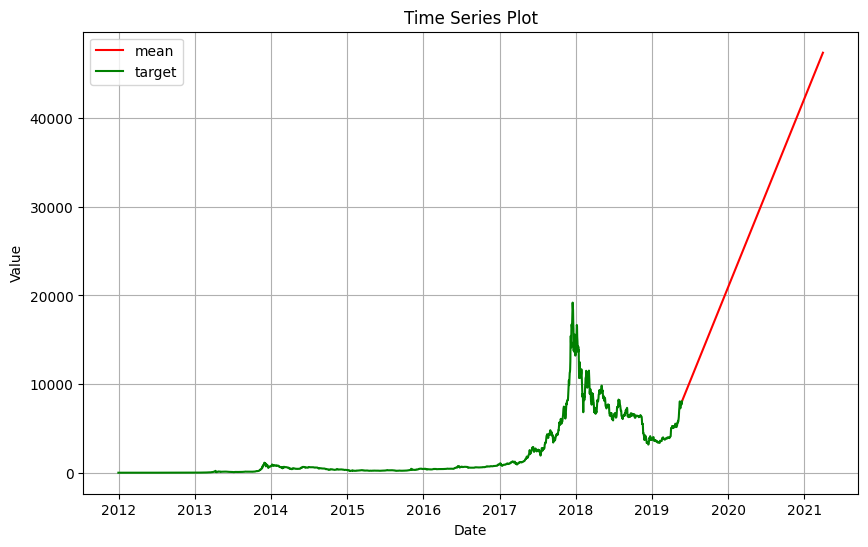

In [ ]:
plot_data(predictions,train_data)

In [ ]:
fast_valid_loss = predictor.evaluate(train_data)
fast_test_loss = predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: ETS
Model not specified in predict, will default to the model with the best validation score: ETS


In [ ]:
fast_test_loss

{'MSE': -259721066.99212298}

In [ ]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Theta,-1.979157e+08,-2.833879e+07,0.436572,0.354018,0.015128,4
1,Naive,-2.101210e+08,-2.902806e+07,0.111730,0.111927,0.015433,1
2,SeasonalNaive,-2.119323e+08,-2.985244e+07,0.116127,0.111298,0.012006,2
3,WeightedEnsemble,-2.597211e+08,-2.788917e+07,33.135488,3.136527,0.911368,7
4,ETS,-2.597211e+08,-2.788917e+07,33.130825,3.136527,0.013002,3
5,RecursiveTabular,-2.706141e+08,-3.269251e+07,13.896057,15.082132,1.464130,5
6,DirectTabular,-3.531305e+08,-5.079302e+07,0.218637,0.184425,1.134803,6


In [ ]:
def plot_single_timeseries(train_data, predictions, test_data, item_id):
    plt.figure(figsize=(15, 3))

    y_past = train_data.loc[item_id]["target"]
    y_pred = predictions.loc[item_id]
    y_test = test_data.loc[item_id]["target"][-676:]

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.plot(y_past[-1000:], label="Past Time Series", color=colors[0], linestyle='-')
    plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
    plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

    #plt.fill_between( y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Predictions for Item {item_id}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_multiple_timeseries(train_data, predictions, test_data, item_ids_to_plot):

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.figure(figsize=(13, 13))
    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(5, 1, i + 1)

        y_past = train_data.loc[item_id]["target"]
        y_pred = predictions.loc[item_id]
        y_test = test_data.loc[item_id]["target"][-676:]

        plt.plot(y_past[-1000:], label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

        #plt.fill_between(y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

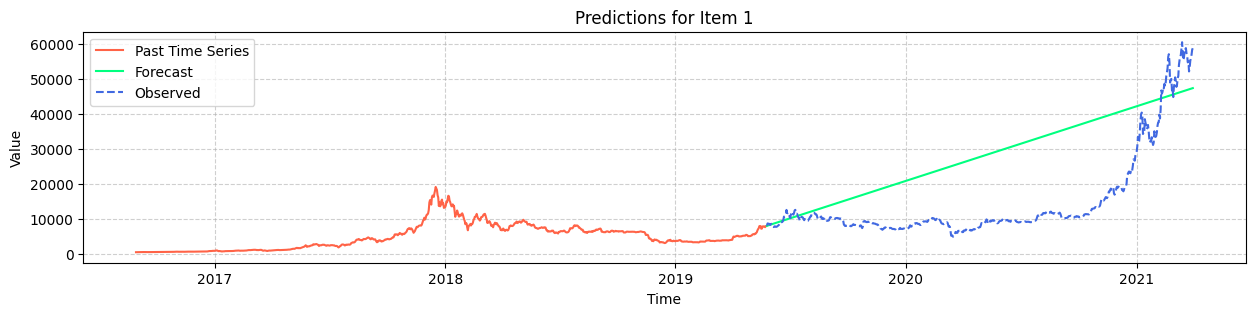

In [ ]:
plot_single_timeseries(train_data, predictions, test_data, item_id=1)

In [ ]:
predictor

#### Best Quality

##### Model Training

In [ ]:
%%time
multiple_timeseries_path = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test"
model_path_medium_quality = "bitcoin-quarterly-medium_quality"
path = os.path.join(multiple_timeseries_path, model_path_medium_quality)

predictor = TimeSeriesPredictor(
    prediction_length=676,
    path=path,
    target="target",
    eval_metric="MSE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    random_seed=42
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/bitcoin_model_test/bitcoin-quarterly-medium_quality'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          8
GPU Count:          1
Memory Avail:       48.44 GB / 50.99 GB (95.0%)
Disk Space Avail:   3.25 GB / 15.00 GB (21.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 676,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full'

In [ ]:
predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
                   model     score_val  pred_time_val  fit_time_marginal  \
0       WeightedEnsemble -1.387341e+07      34.942961           2.220984   
1  DynamicOptimizedTheta -1.387341e+07      34.942961          33.922309   
2                AutoETS -1.438117e+07      26.441345           2.091586   
3             CrostonSBA -1.513416e+07      11.641991           2.576037   
4              AutoARIMA -1.521206e+07      24.923765          24.870463   
5          SeasonalNaive -1.527679e+07       0.127679           0.242797   
6       RecursiveTabular -1.657250e+07      14.000641          45.369768   
7                   NPTS -2.426902e+07      12.129215           8.971258   
8          DirectTabular -2.587574e+07       0.188397           2.305016   

   fit_order  
0          9  
1          5  
2          4  
3          2  
4          6  
5          1  
6          7  
7          3  
8          8

{'model_types': {'SeasonalNaive': 'MultiWindowBacktestingModel',
  'CrostonSBA': 'MultiWindowBacktestingModel',
  'NPTS': 'MultiWindowBacktestingModel',
  'AutoETS': 'MultiWindowBacktestingModel',
  'DynamicOptimizedTheta': 'MultiWindowBacktestingModel',
  'AutoARIMA': 'MultiWindowBacktestingModel',
  'RecursiveTabular': 'MultiWindowBacktestingModel',
  'DirectTabular': 'MultiWindowBacktestingModel',
  'WeightedEnsemble': 'TimeSeriesGreedyEnsemble'},
 'model_performance': {'SeasonalNaive': -15276785.664669333,
  'CrostonSBA': -15134163.253770072,
  'NPTS': -24269019.371636216,
  'AutoETS': -14381172.71907238,
  'DynamicOptimizedTheta': -13873414.377206022,
  'AutoARIMA': -15212058.62656553,
  'RecursiveTabular': -16572499.731279228,
  'DirectTabular': -25875744.236119878,
  'WeightedEnsemble': -13873414.377206022},
 'model_best': 'DynamicOptimizedTheta',
 'model_paths': {'SeasonalNaive': ['SeasonalNaive'],
  'CrostonSBA': ['CrostonSBA'],
  'NPTS': ['NPTS'],
  'AutoETS': ['AutoETS'],
  

##### Model Eval

In [ ]:
predictions = predictor.predict(train_data, model='DynamicOptimizedTheta', random_seed=42)
predictions

mean          0.1          0.2          0.3  \
item_id timestamp                                                        
1       2019-05-26  8018.124389  7799.947672  7864.568458  7912.184247   
        2019-05-27  8049.296856  7719.619950  7822.687256  7899.008712   
        2019-05-28  8075.675220  7634.195183  7770.554158  7853.963040   
        2019-05-29  8088.964050  7634.096752  7722.955570  7850.046377   
        2019-05-30  8071.144763  7560.169715  7688.430921  7817.625027   
...                         ...          ...          ...          ...   
        2021-03-27  8045.585665  3092.958742  4882.726698  6396.142789   
        2021-03-28  8018.124389  3161.278268  4752.168532  6401.585102   
        2021-03-29  8049.296856  3218.888566  5072.283127  6452.315806   
        2021-03-30  8075.675220  3066.068061  5171.772852  6517.154224   
        2021-03-31  8088.964050  3122.357882  5137.080314  6518.830482   

                            0.4          0.5          0.6           0.7  \
item_id timestamp                                                         
1       2019-05-26  7976.344417  8027.760692  8082.950920   8132.091082   
        2019-05-27  7969.218239  8033.127000  8088.694677   8167.066549   
        2019-05-28  7962.961312  8040.593506  8140.614079   8225.161110   
        2019-05-29  7921.596568  7990.508654  8105.997464   8232.093846   
        2019-05-30  7914.316413  8008.371591  8118.434877   8248.369845   
...                         ...          ...          ...           ...   
        2021-03-27  7457.526664  8776.449741  9765.009097  10535.109476   
        2021-03-28  7469.805676  8720.074158  9799.977009  10529.673188   
        2021-03-29  7506.259954  8794.604912  9914.863859  10660.258260   
        2021-03-30  7482.681572  8849.580888  9971.843384  10724.386401   
        2021-03-31  7497.541924  8822.246481  9852.107088  10825.247398   

                             0.8           0.9  
item_id timestamp                               
1       2019-05-26   8186.721806   8282.994157  
        2019-05-27   8258.844860   8384.305809  
        2019-05-28   8331.351719   8470.302130  
        2019-05-29   8330.521937   8462.293476  
        2019-05-30   8350.239044   8563.338633  
...                          ...           ...  
        2021-03-27  12124.445356  13621.826943  
        2021-03-28  11944.975154  13657.742037  
        2021-03-29  11996.725649  13690.059565  
        2021-03-30  12053.616627  13640.628841  
        2021-03-31  12076.748573  13635.148959  

[676 rows x 10 columns]

In [ ]:
def plot_data(df, true_pred):
    plt.figure(figsize=(10, 6))

    # Plot the mean as a line
    plt.plot(df.index.get_level_values('timestamp'), df['mean'], label='mean', color='red')

    true_pred = true_pred.reset_index()
    # Plot the true predictions as a line
    plt.plot(true_pred['timestamp'], true_pred['target'], label='target', color='green')

    # Plot the other quantiles as an area plot
    for column in df.columns:
        if column != 'mean':
            pass
            #upper = df['mean'] + (df['mean'] - df[column])
            #lower = df['mean'] - (df['mean'] - df[column])
            #plt.fill_between(df.index.get_level_values('timestamp'), upper, lower, color='blue', alpha=0.1)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


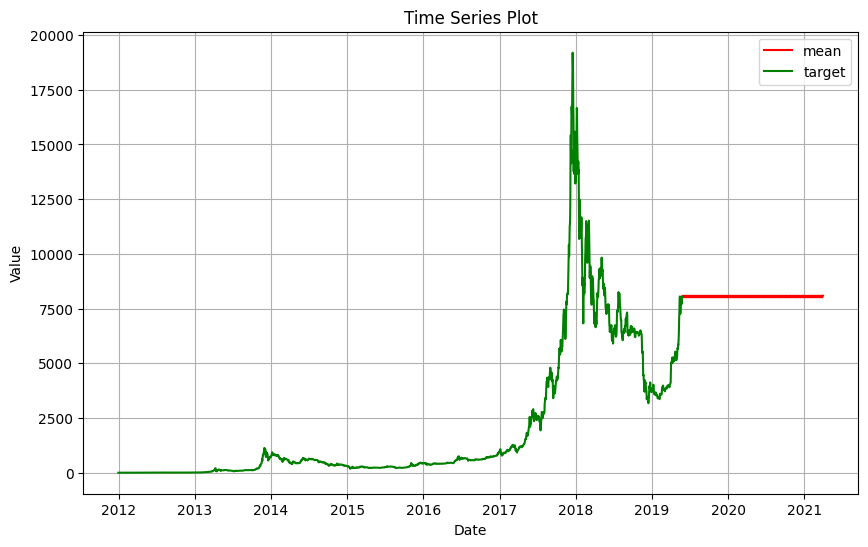

In [ ]:
plot_data(predictions,train_data)

In [ ]:
fast_valid_loss = predictor.evaluate(train_data)
fast_test_loss = predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: DynamicOptimizedTheta
Model not specified in predict, will default to the model with the best validation score: DynamicOptimizedTheta


In [ ]:
fast_test_loss

{'MSE': -209973191.259383}

In [ ]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,AutoARIMA,-2.078276e+08,-1.521206e+07,7.645160,24.923765,24.870463,6
1,WeightedEnsemble,-2.099732e+08,-1.387341e+07,0.624596,34.942961,2.220984,9
2,DynamicOptimizedTheta,-2.099732e+08,-1.387341e+07,0.618203,34.942961,33.922309,5
3,SeasonalNaive,-2.119323e+08,-1.527679e+07,0.113448,0.127679,0.242797,1
4,CrostonSBA,-2.262236e+08,-1.513416e+07,2.899300,11.641991,2.576037,2
5,AutoETS,-2.597211e+08,-1.438117e+07,3.771257,26.441345,2.091586,4
6,RecursiveTabular,-2.706141e+08,-1.657250e+07,13.970780,14.000641,45.369768,7
7,NPTS,-3.128820e+08,-2.426902e+07,12.843633,12.129215,8.971258,3
8,DirectTabular,-3.531305e+08,-2.587574e+07,0.199718,0.188397,2.305016,8


In [ ]:
def plot_single_timeseries(train_data, predictions, test_data, item_id):
    plt.figure(figsize=(15, 3))

    y_past = train_data.loc[item_id]["target"]
    y_pred = predictions.loc[item_id]
    y_test = test_data.loc[item_id]["target"][-676:]

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.plot(y_past[-100:], label="Past Time Series", color=colors[0], linestyle='-')
    plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
    plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

    #plt.fill_between( y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Predictions for Item {item_id}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_multiple_timeseries(train_data, predictions, test_data, item_ids_to_plot):

    colors = ['#FF6347', '#00FF7F', '#4169E1', '#FF69B4']

    plt.figure(figsize=(13, 13))
    for i, item_id in enumerate(item_ids_to_plot):
        plt.subplot(5, 1, i + 1)

        y_past = train_data.loc[item_id]["target"]
        y_pred = predictions.loc[item_id]
        y_test = test_data.loc[item_id]["target"][-676:]

        plt.plot(y_past[-100:], label="Past Time Series", color=colors[0], linestyle='-')
        plt.plot(y_pred["mean"], label="Forecast", color=colors[1], linestyle='-')
        plt.plot(y_test, label="Observed", color=colors[2], linestyle='--')

        #plt.fill_between(y_pred.index, y_pred["0.1"], y_pred["0.9"], color=colors[3], alpha=0.2, label="10%-90% Confidence Interval")

        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"Predictions for Item {item_id}")
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

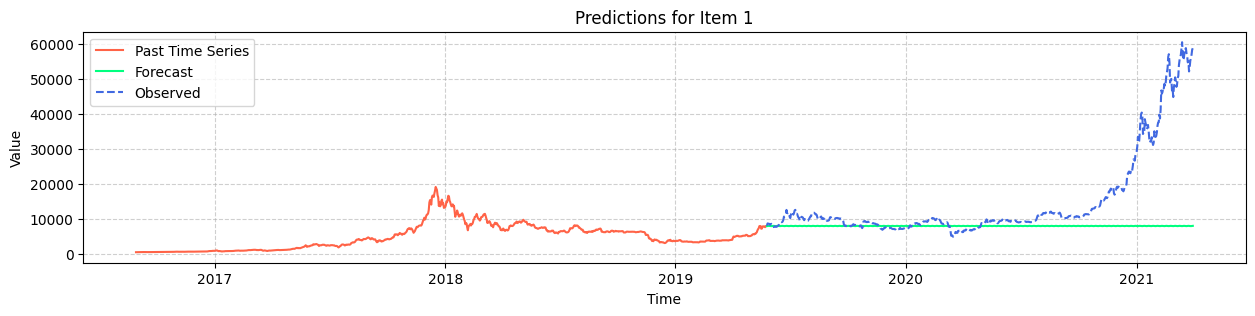

In [ ]:
plot_single_timeseries(train_data, predictions, test_data, item_id=1)

## Other EXP

In [ ]:
dataset = get_dataset("tourism_monthly")

### Plot

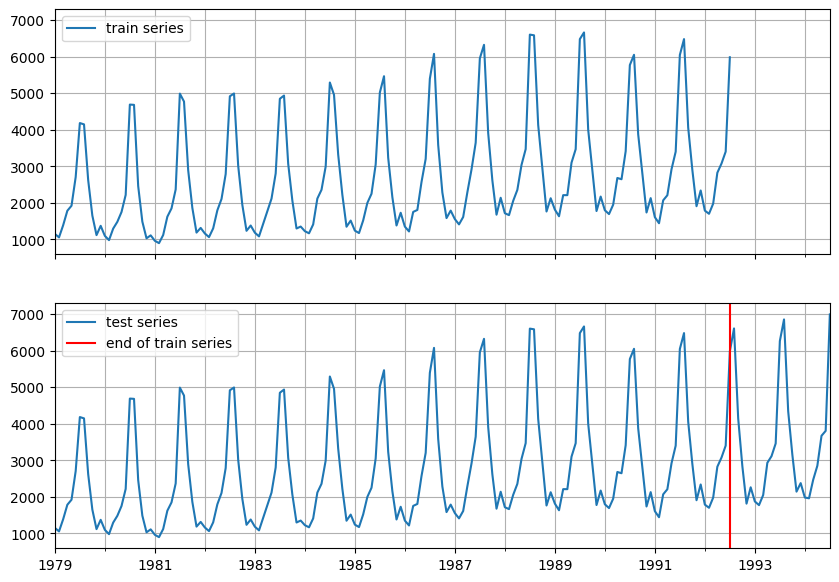

In [ ]:
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

### Preprocess Data

Before building our model, we must first convert our dataset to a format that AG-TS understands.

AG–TS expects the data in a “melted” format: <time series ID, timestamp, target>. We achieve this using the following function:

In [ ]:
def long_format(gluon_dataset):

  data_ds = [{ 'item_id': x['item_id'],  'start': x['start'], 'target': x['target'] } for x in gluon_dataset]
  data_ds = [{
      'item_id': data['item_id'],
      'start': [date.strftime('%Y-%m') for date in [data['start'] + i for i in range(len(data['target']))]],
      'target': data['target']
  } for data in data_ds]


  pandas_df = pd.DataFrame(data_ds).explode(['start','target'])
  return pandas_df

train = long_format(dataset.train)
test = long_format(dataset.test)

Next, we convert the train and test pandas dataframes to Autogluon TimeSeriesDataFrame dataframes:

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train,
    id_column="item_id",
    timestamp_column="start"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test,
    id_column="item_id",
    timestamp_column="start"
)

test_data.head()

target
item_id timestamp              
T1      1979-01-01  1149.869995
        1979-02-01  1053.800171
        1979-03-01  1388.879761
        1979-04-01  1783.370239
        1979-05-01  1921.025146

Then, we explicitly specify that our dataset has a monthly frequency – to prevent any warnings from AG-TS later:

In [ ]:
train_data = train_data.reset_index()\
    .groupby('item_id', sort=False)\
    .resample('M', on='timestamp')\
    .sum().drop(columns=['item_id'])

test_data = test_data.reset_index()\
    .groupby('item_id', sort=False)\
    .resample('M', on='timestamp')\
    .sum().drop(columns=['item_id'])

### Model Training

AG-TS provides 4 powerful ensemble presets:

#### Fast Training


The most important arguments are:
- the path where the models will be saved
- the evaluation metric (here MSE),
- the time_limit, which instructs AG-TS to train as many models as possible within a specified time frame. Here, we omit this argument - meaning AG-TS will run until all models have completed training.

In [ ]:
%%time
multiple_timeseries_path = "/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models"
model_path_fast = "tourism-quarterly-fast"
path = os.path.join(multiple_timeseries_path, model_path_fast)

predictor = TimeSeriesPredictor(
    prediction_length=24,
    path= path,
    target="target",
    eval_metric="MSE"
)

predictor.fit(
    train_data,
    presets="fast_training",
    random_seed=42
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/Personal Project/AutoGluon–TimeSeries (AG-TS)/models/tourism-quarterly-fast'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          0
Memory Avail:       11.03 GB / 12.67 GB (87.1%)
Disk Space Avail:   3.61 GB / 15.00 GB (24.0%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 42,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'targe

CPU times: user 2min 15s, sys: 1.51 s, total: 2min 16s
Wall time: 2min 21s
